<a href="https://colab.research.google.com/github/rexx-coder/rexx-coder/blob/main/Volatility_estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

!pip install yfinance
import yfinance as yf

asset = "AAPL"
data = yf.download(asset, start="2018-01-01", end="2025-12-01")
data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)

/tmp/ipython-input-3675170794.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(asset, start="2018-01-01", end="2025-12-01")
[*********************100%***********************]  1 of 1 completed


Standard deviation of log returns × √252


In [ ]:
hist_vol = data['LogReturn'].std() * np.sqrt(252)
hist_vol


np.float64(0.30901411135454243)

Rolling Volatility[20, 60, 120]


<Axes: xlabel='Date'>

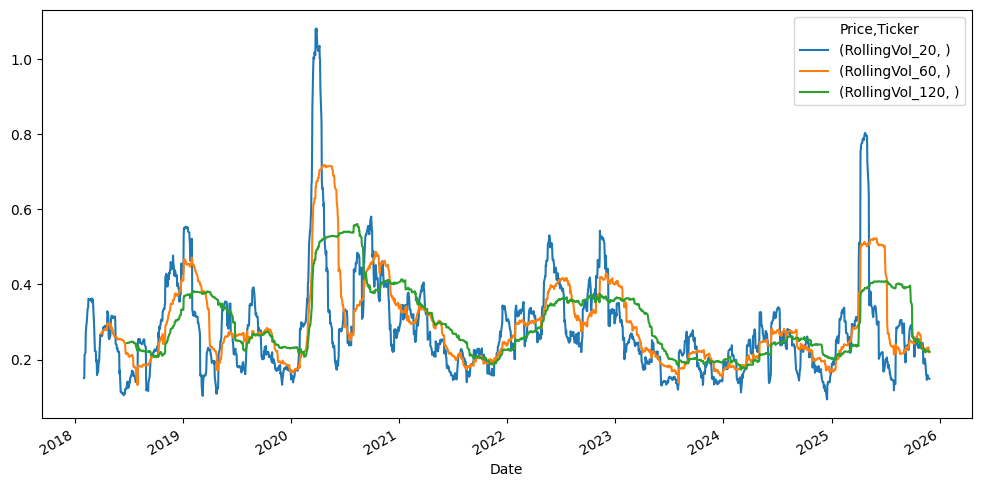

In [ ]:
for window in [20, 60, 120]:
    data[f"RollingVol_{window}"] = data['LogReturn'].rolling(window).std() * np.sqrt(252)

data[['RollingVol_20','RollingVol_60','RollingVol_120']].plot(figsize=(12,6))


EWMA Volatility


In [ ]:
lambda_ = 0.94
# Initialize the current EWMA variance, which will be updated in the loop.
# This value acts as the sigma_{t-1}^2 for the first return.
current_ewma_variance_estimate = data['LogReturn'].var()

# This list will store the calculated EWMA variances for each timestamp
# so that its length matches the DataFrame.
ewma_variances_for_column = []

for r in data['LogReturn']:
    # Calculate the next EWMA variance based on the previous estimate and current return
    current_ewma_variance_estimate = lambda_ * current_ewma_variance_estimate + (1 - lambda_) * r**2
    ewma_variances_for_column.append(current_ewma_variance_estimate)

# Assign the list of calculated EWMA variances (after taking sqrt and annualizing)
# to the new column. The length of ewma_variances_for_column will now match data.
data['EWMA_0.94'] = np.sqrt(ewma_variances_for_column) * np.sqrt(252)

In [ ]:
def compute_realized_volatility_around_event(data_df, event_date, days):
    """
    Computes realized volatility for a specified number of days before and after an event date.

    Args:
        data_df (pd.DataFrame): DataFrame with a DatetimeIndex and a 'LogReturn' column.
        event_date (str or datetime): The date of the event.
        days (int): The number of trading days before and after the event.

    Returns:
        tuple: (realized_vol_pre, realized_vol_post)
               realized_vol_pre (float): Annualized realized volatility before the event.
               realized_vol_post (float): Annualized realized volatility after the event.
               Returns np.nan if data is insufficient for a period.
    """
    event_dt = pd.to_datetime(event_date)

    # Define pre-event period (excluding the event day)
    pre_event_start = event_dt - pd.Timedelta(days=days)
    pre_event_end = event_dt - pd.Timedelta(days=1)
    pre_event_returns = data_df.loc[pre_event_start:pre_event_end, 'LogReturn'].dropna()

    # Define post-event period (excluding the event day)
    post_event_start = event_dt + pd.Timedelta(days=1)
    post_event_end = event_dt + pd.Timedelta(days=days)
    post_event_returns = data_df.loc[post_event_start:post_event_end, 'LogReturn'].dropna()

    # Calculate annualized volatility, returning NaN if no returns are available
    realized_vol_pre = np.nan
    if not pre_event_returns.empty:
        realized_vol_pre = pre_event_returns.std() * np.sqrt(252)

    realized_vol_post = np.nan
    if not post_event_returns.empty:
        realized_vol_post = post_event_returns.std() * np.sqrt(252)

    return realized_vol_pre, realized_vol_post

# Example Usage:
# Choose an event date within your data range, e.g., '2020-01-15'
event_date_example = '2020-01-15'
days_window = 10

pre_volatility, post_volatility = compute_realized_volatility_around_event(data, event_date_example, days_window)

print(f"Realized Volatility {days_window} days before {event_date_example}: {pre_volatility:.4f}")
print(f"Realized Volatility {days_window} days after {event_date_example}: {post_volatility:.4f}")

Realized Volatility 10 days before 2020-01-15: 0.2111
Realized Volatility 10 days after 2020-01-15: 0.1198


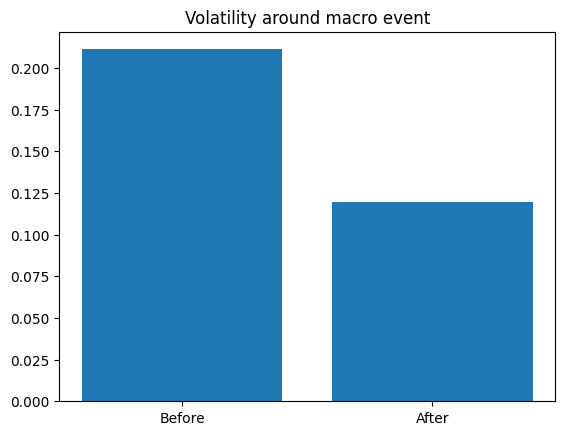

In [ ]:
import matplotlib.pyplot as plt

vols = [pre_volatility, post_volatility]
labels = ['Before', 'After']

plt.bar(labels, vols)
plt.title("Volatility around macro event")
plt.show()